In [1]:
##### Import Libraries
import os
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
from zipfile import ZipFile
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words('english')


##### Libraries for training LSTM NN
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahil.bagheri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [2]:
##### Set The Directory
%cd "C:\Users\rahil.bagheri\OneDrive - REI Systems Inc\Desktop"

C:\Users\rahil.bagheri\OneDrive - REI Systems Inc\Desktop


Taken Steps:
Step 0: Import Data
Step 1: Clean Data
Step 2: Explore Data
Step 3: Prepare Data for NN
Step 4: Fitting a Bidirectional LSTM NN
Step 5: Evaluating The Model
Step 6: Train Other LSTM models

To import the data, I unzipped it and saved it on the directory as 'tem_tags". The important features are extracted and saved in a pandas data frame, data_all. 

In [3]:
################################################# Step 0: Import Dataset ##########################################################
# Unzipe the file. The following code unzipe and save the .tags files in a temporary file, temp_tags. 
# It creates a ZipFile Object and load sgmb-2.2.0.zip in it

with ZipFile('gmb-2.2.0.zip', 'r') as zipObj:
   # get a list of all archived file from the zip
   listOfFileNames = zipObj.namelist()
   # iterate over the file names
   for fileName in listOfFileNames:
       # check filename endswith tags
       if fileName.endswith('.tags'):
           # extract a single file from zip
           zipObj.extract(fileName, 'temp_tags')

The list of important features for this analysis is:
Word: It is the actual word from different articles. It also includes numbers and separators like "" or ".". The total word count is 1354149.
Pos: It represents the position of the word in the sentence which I didn’t include in my analysis.
Token: It has the same values as the word column, but all letters are lowercased. 
Tag: It is a class of entity names like "org" for an organization, or "per" meaning person. Most of the words are not labeled and tagged as “O”.   There were some tags with less than 15 occurrences in the data which weren't labeled accurately. So, I labeled them as "O".
The data is highly imbalanced, so first I removed the stop words and numbers to reduce the un_taged labels. But since I am going to use Sequential RNN and LSTM which depends on the context of the previous word, I am not removing stopwords. 
. Also, a new feature is added, "sentence_seq", that represents which sentences words and tags belong to. 


In [4]:
################################################ Step 1: Clean Data ########################################################
##### Merging .tag Files 

## initiate some lists
frame = []
all_files = []
previous_seq = 1

def SentenceSeq(flag):
    global previous_seq
    previous_seq = previous_seq if flag == 0 else previous_seq + 1
    return previous_seq


def Merge_Clean_Data(Path):
    '''This function make a list of all tag files and concatenate them.
    Input:Path is the name of the file
    
    output:data is a pandas dataframe with 9 columns and 1354149 rows.
    
    all_files is the list of all the .tag files'''
    
    list_dirs = os.walk(Path) 
    for root, dirs, files in list_dirs:      
        for f in files:
            if f.endswith('.tags'):
                all_files.append(os.path.join(root, f))
                
    for filename in all_files:
        df = pd.read_csv(filename, sep='\t', header=None, engine = "python")
        frame.append(df) 
        
    data = pd.concat(frame, axis=0, ignore_index=True)
    
    data.columns = ["word", "pos", "token", "tag", "var1","var2","var3","var4","var5","var6"] # add headers
    data = data.drop(["var1","var2","var3","var4","var5","var6"],axis=1) # drop the vars which are not considered in the analysis
    
    # create a flag variable. falg == 1 at the end of the sentence.
    data['flag'] = data.word.apply(lambda x: 1 if x == "." else 0) 
    
    # create a variable which represents sentence number. The index increases by 1 if word == ".". Sentences are seperated by "."
    data['sentence_seq'] = data[['flag']].apply(lambda x: SentenceSeq(*x), axis=1)  
    
    ## replace the tags less than 15 with no label, "O".
    data.loc[data.groupby('tag').tag.transform('count').lt(15), 'tag'] = "O"
    
    ## data['word'] = data['word'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return (data)


In [5]:
##### Merged Data saved in data_all
## apply "MergeData" function for data visualization purposes 
data_all = Merge_Clean_Data("gmb-2.2.0")

The number rows in the GBM corpus is: 1354149.
The number of different words in the GBM corpus is: 39427.
The number of sentences in the GBM corpus is: 61762.
The list of unique tags is ['gpe-nam', 'eve-ord', 'tim-nam', 'org-nam', 'geo-nam', 'per-fam', 'tim-dat', 'eve-nam', 'O', '[]', 'per-ini', 'tim-moy', 'art-nam', 'tim-dow', 'per-giv', 'nat-nam', 'per-nam', 'tim-yoc', 'per-tit', 'per-ord', 'org-leg', 'tim-clo'].
The frequency of tags are : 22.


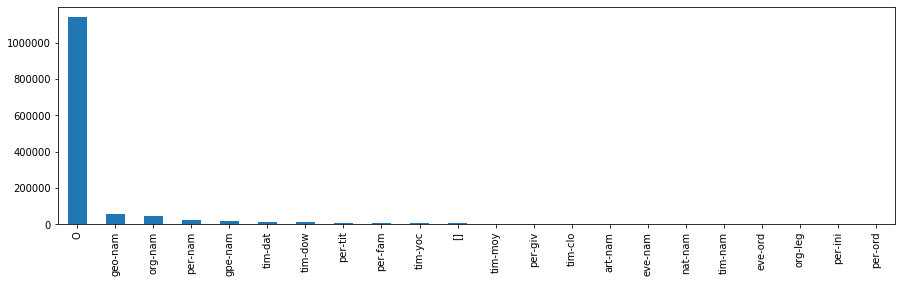

In [6]:
################################################### Step 2: Explore Data ###################################################

num_rows = data_all.shape[0]
num_sentences = data_all['sentence_seq'].max()
list_words = list(set(data_all["word"].values)); num_words = len(list_words)
list_tags = list(set(data_all["tag"].values)) ; num_tags = len(list_tags)

print('The number rows in the GBM corpus is: {}.'.format(num_rows))
print('The number of different words in the GBM corpus is: {}.'.format(num_words))
print('The number of sentences in the GBM corpus is: {}.'.format(num_sentences))
print('The list of unique tags is {}.'.format(list_tags))
print('The frequency of tags are : {}.'.format(num_tags))

fig, ax = plt.subplots(figsize=(15,4))
data_all['tag'].value_counts().plot(ax=ax, kind='bar')

I used the SentenceGetter class to get the sentences and the relevant tags as a list using sentence number,"sentence_seq".

In [7]:
#######################################################  Step 3: Prepare Data for NN #########################################
 
class SentenceGetter(object):
    
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg_func = lambda x: [(w, t) for w,t in zip(x["word"].values.tolist(),x["tag"].values.tolist())]
        self.grouped = self.df.groupby("sentence_seq").apply(agg_func)
        self.sentences = [x for x in self.grouped]
    

In [8]:
getter = SentenceGetter(data_all)
sentences = getter.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'geo-nam'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'geo-nam'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'gpe-nam'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O')]


To define the number of recurrent layers, we need a better understanding of the length of the sentences. The longest sentence has 106 words and on average they have 21 words.

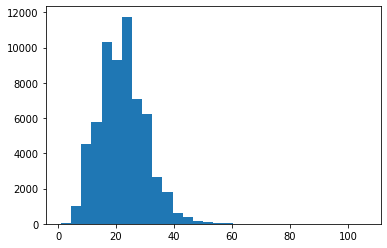

Maximum length of sentences is : 106.
Average length of sentences is : 21.925277678831645.


In [9]:
## How number of words distributed in the sentences?!!
plt.hist([len(t) for t in sentences], bins=30)
plt.show()

## maximum sentence has 106 words
print('Maximum length of sentences is : {}.'.format(max([len(t) for t in sentences])))

## sentences are on average 21 words long.
print('Average length of sentences is : {}.'.format(np.mean([len(t) for t in sentences]))) 

In [10]:
print("First 2 sentences are:\n",sentences[0:2])

First 2 sentences are:
 [[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'geo-nam'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'geo-nam'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'gpe-nam'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O')], [('.', 'O'), ('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('\tLQU\t', '[]'), ('Bush', 'per-fam'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('\tRQU\t', '[]'), ('and', 'O'), ('\tLQU\t', '[]'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O')]]


Here, I mapped the sentences to a sequence of indexes, up to 60, and then pad the sequence to explore bidirectional LSTM. This sequence is taken as input and one hot endcoded tags as output. The reason I choose 60 was that most of the words in a sentence weren't labeled or wrongly labeled and by reducing the sequence we wouldn't lose that much information. It even makes the tags more balanced. 

In [11]:
##### Prepare the data for training Bidirectional LSTM NN by creating a sequence classification  

def mapping(list_words, list_tags, MAXLEN):
    '''
    This function reads a list of words, tags and the maximum length of senetnce. Then, mapps the sentences to a sequence of
    numbers and then padds the sequence," post padding". It also change the tags, y to categorical since it is requiered in sequential LSTM. 
    Input: 
    
       list_words : list of the unique words
       list_tags : list of the unique tags
       MAXLEN : dimensional word indices. I considered max length of sentences as 60. All the senetences must have the same 
       input length. If the length of a sentence is less than 60, some additional tokens will be added to the end of the sentence.
       If it is more, they will be removed. Since, most of the words are not labeled, "O", we are not going to loose that much 
       information.   
    '''
    ## create a Word Dictionary
    dic_word = {word: i for i, word in enumerate(list_words)}  ### for example, "ensuring" is the first word in the list and its index is 0
    ## create a Tag Dictionary
    dic_tag = {tag: i for i, tag in enumerate(list_tags)} ### for example, 'nat-nam' is labeled 0 in the list_tags
    ## looping through the word and tag tuples 
    x = [[dic_word[word[0]] for word in sent] for sent in sentences]
    y = [[dic_tag[word[1]] for word in sent] for sent in sentences]
    
    ## in order to feed sentences into a LSTM network, they  need to be the same size. I used the post padding technique here.
    ## it transforms a list of sequences in to Numpy array with the length of MAXLEN == 60.
    X_padded = pad_sequences(maxlen=MAXLEN, sequences=x, padding="post", value=num_words - 1)
    Y_padded = pad_sequences(maxlen=MAXLEN, sequences=y, padding="post", value=dic_tag["O"])
    
    # Making tags in one hot encoded form for NN model.
    Y_padded_dummy = [to_categorical(i, num_classes=num_tags) for i in Y_padded]
    
    return(X_padded,Y_padded_dummy)

In [12]:
## mapping outputs, both words and tags, are saved in X nad Y arrays
X, Y = mapping(list_words, list_tags, 60)

As requested, I saved 30% of the data for testing the final model and used 70%  to fit the model on. Based on the average length of sentences, I considered the length of sequences as 60. 

In [13]:
## Split the data to training, 70%, and testing, 30%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)

In [14]:
##### Set up values
MAXLEN = 60 # max length of sentences 
N_LSTM = 60 # number of LSTM embedding layers
BS = 48 # batch size
EPOCS = 3 # number of epocs

In [406]:
## plot the loss and accuracy history for train and valid dataset

def accuracy_plot(hist):
    loss = hist.history['accuracy']
    val_loss = history.history['val_accuracy']

    plt.figure(figsize=(10,8))
    plt.plot(loss,"--", linewidth=3 , label="train")
    plt.plot(val_loss, linewidth=3 , label="test")

    plt.legend(['train','test'], loc='upper left')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Model accuracy')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

Here,I developed a deep bidirectional long short-term memory (LSTM) recurrent neural network for this sequence multi-classification data. The reason I chose Bi_LSTM is that this RNN’s provides a very elegant way of dealing with sequential data while memorizing big correlations between sequence points.  It is widely used for language modeling, POS and NER tasks, [https://arxiv.org/pdf/1603.01354.pdf]. 
Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper which takes the embedding recurrent layer. Due to saving some time, I fitted LSTM with 3 epochs. It is trained on 90% of data and evaluated on 10% in batches of 48.  

In [409]:
########################################## Step 4: Fitting a Bidirectional LSTM NN ################################################

def get_bilstm_model(num_words , MAXLEN , N_LSTM, dropout):
    
    '''
    This function is defined to return the Bidirectional LSTM model
    Inputs:
    num_words: Sequence of words
    MAXLEN : the maximum length of sentences
    N_LSTM : number of LSTM units
    dropout : percentage chance of setting inputs to zero
    
    '''
    # Specifying the input shape, 60 dimensional word embedding
    input = Input(shape=(MAXLEN,))

    # Embedding layer considered as the first layer
    model = Embedding(input_dim=num_words, output_dim=MAXLEN, input_length=MAXLEN)(input)

    # Adding dropout layer to the model with a 20% chance of setting inputs to zero to reduce the overfitting
    model = Dropout(dropout)(model)

    # Bidirectional LSTM to learn from both forward and backward context. This wrapper takes a recurrent layer
    model = Bidirectional(LSTM(units=N_LSTM, return_sequences=True, recurrent_dropout=0.1))(model)

    # Adding a TimeDistributed to a Dense layer on each 60 timesteps with softmax output layer. I used this wrapper around the output
    # to make the LSTM hidden layer returns sequence of values rather than a single value. 
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(model) 

    model = Model(input, out)

    # Compile the learner. Because this is a multi classification problem, the categorical_crossentropy log loss is used. 
    # The efficient ADAM optimization algorithm is used to find the weights and the accuracy metric is calculated for each epoch
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

def train_bilstm_model(model, BS, EPOCS, val_split):
    '''
    this function trains the Bi LSTM model for the model.
    Input:
    model: the defined model
    BS: size of the batch
    EPOCS: number of epocs
    val_split : the percentage of val-train split.
    '''
    ## 10 fold cross validation technique is being used. 
    history = model.fit(X_train, np.array(y_train), batch_size=BS, epochs=EPOCS, validation_split=val_split, verbose=1)

    return accuracy_plot(history) , model.summary() , history

C:\Users\rahil.bagheri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38909 samples, validate on 4324 samples
Epoch 1/3
38909/38909 [==============================] - 76s 2ms/step - loss: 0.2240 - accuracy: 0.9550 - val_loss: 0.0808 - val_accuracy: 0.9779
Epoch 2/3
38909/38909 [==============================] - 80s 2ms/step - loss: 0.0559 - accuracy: 0.9846 - val_loss: 0.0476 - val_accuracy: 0.9868
Epoch 3/3
38909/38909 [==============================] - 80s 2ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.0428 - val_accuracy: 0.9879


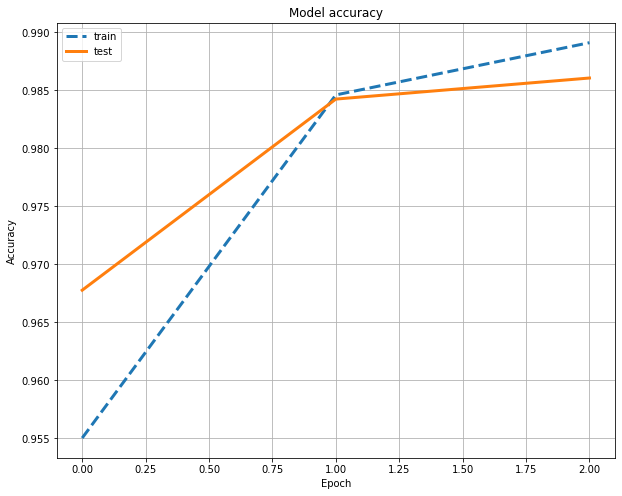

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 60, 60)            2365620   
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 120)           58080     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 60, 22)            2662      
Total params: 2,426,362
Trainable params: 2,426,362
Non-trainable params: 0
_________________________________________________________________


In [410]:
model = get_bilstm_model(num_words , MAXLEN ,N_LSTM, 0.2)
_,_,history = train_bilstm_model(model , BS, EPOCS, 0.1)

In [411]:
##### Predict the X_test tags. In total, 18529 instances to test the model on. 
test_prediction = model.predict(X_test, verbose=1)

18529/18529 [==============================] - 5s 248us/step


The accuracy plot shows how well the model was able to generalize to the new sequences by accuracy close to 98%. But as it is shown in the confusion matrix, it couldn't predict some tags, like eve-ord and tim-clo. That might be due to a lack of enough data for these specific tags. Or because they weren't labeled correctly in the training phase. 
Since the tag labels are highly imbalanced and the model didn't predict some tags, I preferred to evaluate the model Precision and Recall or even a better metric like F1 score. But for a more detailed evaluation process, it is better to exclude the high-frequency tags while calculating the metrics. 

In [412]:
###################################################### Step 5: Evaluating The Model #################################################

## convert the multidimensional arrays to 1 D to plot the confusion matrix
Predicted_Values = np.argmax(test_prediction, axis=-1) # Returns the indices of the maximum value, which tag the word is assigned to
Actual_Values = np.argmax(y_test, axis=-1)

predicted_values = Predicted_Values.ravel()
actual_values = actual_values.ravel()


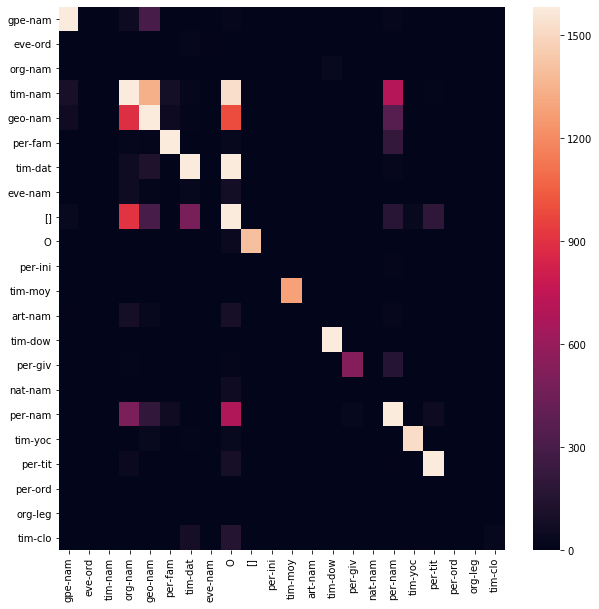

In [413]:
##### Confusion Matrix
cf = confusion_matrix(actual_values,predicted_values)
## In the confusion matrix Y-axis is the actual tags and X-axis is the predicted tags
## As it is shown, the model couldnt predict some tags. The ones with darkest purple and zero value on diagonal.
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(cf, ax=ax,yticklabels=mylist, xticklabels=list_tags, robust=True)

To analyze which tags weren't predicted well, I found the 10 most misclassified tags. It is helping us to know the data and model capability better in case of being interested to add more cleaning steps and understand the ways words are tagged. The results show the model couldn't predict "O" instead of "tim-dat", top unclassified classes.  

In [414]:
### dictionaries to map tags and indexes 
tag_dic = {i: w for w, i in dic_tag.items()}

### function to get the most disclassified tags
def misclassified(True_class , Predicted_class):
    '''
    This function gets the two actual and predicted arrays and returns the 10 most disclassified tags
    '''
    Predict_tran = np.array([idx2tag[x] for x in Predicted_class]) ; Actual_tran = np.array([tag_dic[x] for x in True_class])
    Actual= pd.Series(Actual_tran.astype(str)) ; Predict = pd.Series(Predict_tran.astype(str))
    DF = pd.concat([Actual, Predict], axis=1) ; DF.columns = ["Actual","Predicted"]
    DF["freq"] = 1
    misclass_df = DF[DF['Actual'] != DF['Predicted']].groupby(['Actual', 'Predicted']).sum().sort_values(['freq'], ascending=False).reset_index()
    misclass_df['pair'] = misclass_df['Actual'] + ' / ' + misclass_df['Predicted']
    misclass_df = misclass_df[['pair', 'freq']].take(range(10))
    
    print("10 most misclassified tags are: ")
    print(30 * "=")
    
    return(list(misclass_df['pair']))

In [415]:
## 10 most diclassified tags is listed below. model couldnt predict organization's name and person's name properly. 
## but it migth be due to the bias in actual dataset itself. For example some names were labeled as org-nam. 
misclassified(actual_values , predicted_values)

10 most misclassified tags are: 


['tim-dat / O',
 'org-nam / O',
 'org-nam / geo-nam',
 'geo-nam / O',
 'O / org-nam',
 'geo-nam / org-nam',
 'org-nam / per-nam',
 'per-nam / O',
 'per-nam / org-nam',
 'O / tim-dat']

In [416]:
##### Now, let's analyze the word tags within each sentence
def PredictTag (array):
    '''
    This function gets an array and returns the predicted tags for each sentence
    Input: 
    array: predicted or actual test values as an array
    Output: tuple of tag values seperated for each sentence
    '''
    out = []
    for i in array:
        out_i = []
        for p in i:
            p_i = np.argmax(p)
            out_i.append(tag_dic[p_i])
        out.append(out_i)
    return out

In [417]:
## and the output is 
predicted_tags = PredictTag(test_prediction)
actual_tags = PredictTag(y_test)
predicted_tags

[['O',
  'O',
  'O',
  'O',
  'O',
  'org-nam',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'geo-nam',
  'O',
  'O',
  'geo-nam',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'geo-nam',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
 

In [418]:
## Since the tags was highly imbalanced it is better to evaluate the model based on f1 score, which is a trade of 
## between recall and precision 

print("F1-score: {:.2%}".format(f1_score(predicted_tags, actual_tags)))
print("recall-score: {:.2%}".format(recall_score(predicted_tags, actual_tags, average='macro')))
print("precision-score: {:.2%}".format(precision_score(predicted_tags, actual_tags, average='macro')))                                  

F1-score: 87.92%
recall-score: 89.04%
precision-score: 86.83%


To evaluate the developed model, I compared the BI_LSTM with one way context learning. The comparison result shows that bidirectional LSTMs can add something more than simply reversing the input sequence, backward or forward. The backward sequence learning requires more Epocs to perform close to forward.

In [403]:
####################################################### Step 6: Train Other LSTM models  #################################################
results = DataFrame()

def get_lstm_model(num_words , MAXLEN , backwards):
    '''
    This function performs same as get_bilstm_model" to compare the "LSTM" to "Bidirectional LSTM".
    Two LSTM models are applied here. First just the Forward LSTM and second the Backward LSTM. 
    
    '''
    model_LSTM = Embedding(input_dim=num_words, output_dim=MAXLEN, input_length=MAXLEN)(input)
    model_LSTM = Dropout(0.2)(model_LSTM)
    model_LSTM = LSTM(units=N_LSTM, return_sequences=True, recurrent_dropout=0.1, go_backwards=backwards)(model_LSTM) 
    out_lstm = TimeDistributed(Dense(num_tags, activation="softmax"))(model_LSTM) 
    model_LSTM = Model(input, out_lstm)
    model_LSTM.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model_LSTM

def train_lstm_model(model, BS, EPOCS):
    loss = list()
    history_LSTM = model.fit(X_train, np.array(y_train), batch_size=BS, epochs=EPOCS, validation_split=0.1, verbose=1)
    loss.append(history_LSTM.history['loss'][0])

    return loss , accuracy_plot(history_LSTM)

C:\Users\rahil.bagheri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38909 samples, validate on 4324 samples
Epoch 1/3
38909/38909 [==============================] - 53s 1ms/step - loss: 0.2692 - accuracy: 0.9496 - val_loss: 0.1123 - val_accuracy: 0.9680
Epoch 2/3
38909/38909 [==============================] - 56s 1ms/step - loss: 0.0845 - accuracy: 0.9761 - val_loss: 0.0649 - val_accuracy: 0.9835
Epoch 3/3
38909/38909 [==============================] - 57s 1ms/step - loss: 0.0505 - accuracy: 0.9862 - val_loss: 0.0497 - val_accuracy: 0.9859


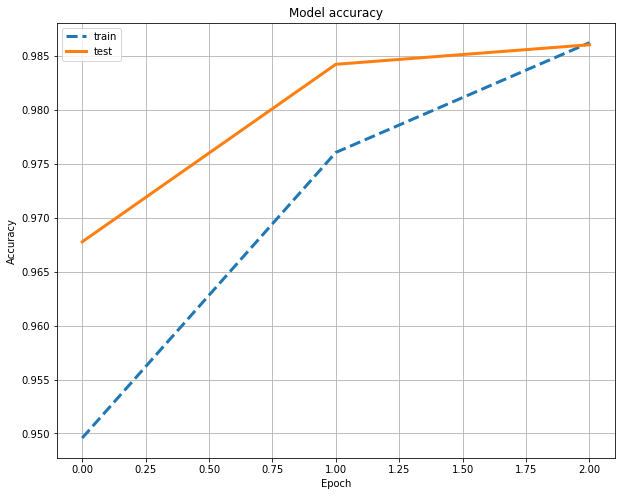

In [404]:
## loss and accuracy results for Forward LSTM
model_LSTM_forw = get_lstm_model(num_words , MAXLEN , False)
results['lstm_forw'] = train_lstm_model(model_LSTM_forw, BS, EPOCS)

C:\Users\rahil.bagheri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38909 samples, validate on 4324 samples
Epoch 1/3
38909/38909 [==============================] - 58s 1ms/step - loss: 0.3970 - accuracy: 0.9398 - val_loss: 0.2931 - val_accuracy: 0.9433
Epoch 2/3
38909/38909 [==============================] - 63s 2ms/step - loss: 0.2955 - accuracy: 0.9425 - val_loss: 0.2863 - val_accuracy: 0.9433
Epoch 3/3
38909/38909 [==============================] - 63s 2ms/step - loss: 0.2922 - accuracy: 0.9425 - val_loss: 0.2856 - val_accuracy: 0.9433


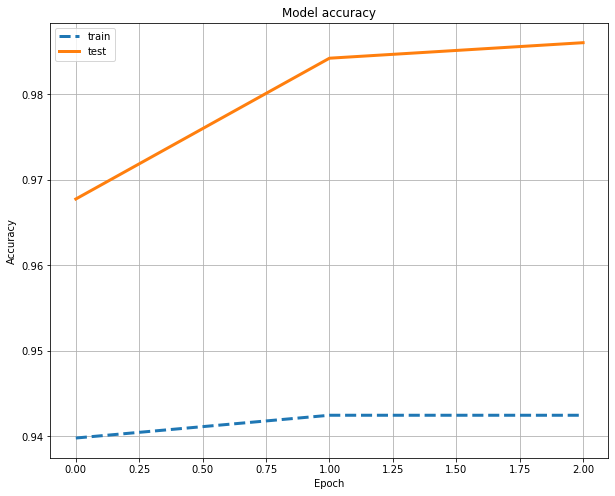

In [405]:
## loss and accuracy results for Backward LSTM. Backward LSTM needs more epocs to start generating good and valid results. 
## But since the purpose was just comparing the LSTM's outputs, I am not fitting the model with more epocs. 
model_LSTM_back = get_lstm_model(num_words , MAXLEN , True)
results['lstm_back'] = train_lstm_model(model_LSTM_back, BS, EPOCS)